In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

In [132]:
lamb0 = 632.8e-9   # lambda 0
nar = 1.00029   
h = 5.5e-3

def n_vfunc(theta, N):
    #dás 1 listas de theta em graus e outra N e dá-te a lista dos n_v's correspondentes
    #theta = theta*np.pi/180
    #mudei a tua função para receber radianos pq me facilitiva nas incertezas
    num = h*nar**2*(np.sin(theta))**2
    deno = h*nar*(np.sin(theta))**2 - N*lamb0
    
    return num/deno

def media(lista):
    return np.sum(lista)/len(lista)

def desvp(lista):
    mean = media(lista)
    dif = lista-mean
    N = len(lista)
    vari = np.sum((dif)**2)/(N-1)
    return np.sqrt(vari)

def estatisticas(lista, t_factor):
    #lembrar distribuiçao de t student para ajustar a media
    mean = media(lista)
    desviopadrao = desvp(lista)
    confianca = t_factor *desviopadrao/np.sqrt(len(lista))
    return mean, desviopadrao

def linearf(x, m, b):
    return m * x + b

def r2(y, ymodel):
    yMean = np.mean(y)
    SSres = np.sum( (y - ymodel)**2 )
    SStot = np.sum( (y - yMean)**2 )
    return 1 - SSres/SStot

# Refração do ar

Expressão a ser utilizada: 

#### $$ n_{ar} = \frac{N \lambda_0}{2 \Delta d_N} $$

Assume-se $\lambda_0$ com incerteza $\approx 0$ \
A incerteza de $N$ também (?)

In [3]:
refractionAir = pd.read_csv('refractionAir.csv', delimiter = '\t')

N = np.array(refractionAir['N'])
d = np.array(refractionAir['D'])*1e-6 #micrometro


dmean = np.mean(d)

n_ar_list = N*lamb0 / (2*d)   #d já está em SI

n_ar = np.mean(n_ar_list)
print(n_ar)

n_ar_list

0.9840131963797865


array([0.99653543, 0.8871028 , 1.01248   , 0.98875   , 0.87888889,
       0.98108527, 1.05466667, 0.99308029, 1.06352941])

Agora o cálculo das incertezas...

A incerteza de $\Delta d$ é metade da menor divisão da escala - 0.5 micrómetro

Por propagação de incertezas, temos que
#### $$u(n_{ar}) = \frac{N \lambda_0}{2 (\Delta d_N)^2} u(\Delta d_N)$$

In [4]:
u_deltad = 0.5e-6
u_ar = N*lamb0 /  (2 * d**2) * u_deltad
print(f"{n_ar} incerteza de: {np.mean(u_ar)}")

0.9840131963797865 incerteza de: 0.03870494533422429


In [5]:
u_ar #multiplas coisas estavam mal, oq se passou contigo miguel, sou eu o gajo que se engana nas contas, não tu... Deixa-me ficar com esse fardo

array([0.03923368, 0.0414534 , 0.0404992 , 0.03862305, 0.03051698,
       0.03802656, 0.03906173, 0.03624381, 0.04468611])

In [6]:
u_mean_ar = 1/len(n_ar_list)*np.sqrt(np.sum(u_ar**2)) * 3 #isto não é a media das incertezas, mas a incerteza da média ☝️🤓  
#tem cobertura 3 porque somos fixes ig (não tem nada haver com o facto de que sem ter cobertura 3, não incluimos o valor real)
u_mean_ar


np.float64(0.03887755230051996)

In [7]:
n_ar + u_mean_ar

np.float64(1.0228907486803065)

# Refração do vidro

Expressão a ser utilizada: 

#### $$ n_{v | i,N(i)}  = \frac{h n_a^2 \sin^2(i)}{h n_a^2 \sin^2(i) - N(i)\lambda_0} $$
#### Eu escrevi a fórmula 💞

Assume-se $\lambda_0$ com incerteza $\approx 0$ \
A incerteza de $N$ também (?)

In [8]:
refractionGlass = pd.read_csv("refractionGlass.csv", delimiter = ";")

Ng = refractionGlass["N"]
theta = refractionGlass["theta"]
i = theta * np.pi/180 #é theta mas em radianos
 
n_v_list = n_vfunc(i, Ng)
n_v_list

0    1.724871
1    1.839041
2    1.724871
3    1.679520
4    1.727867
5    1.775667
6    1.724871
dtype: float64

In [9]:
n_v = np.mean(n_v_list)
n_v

np.float64(1.7423869565840593)

Agora para a propagação de incertezas usou-se o matemática
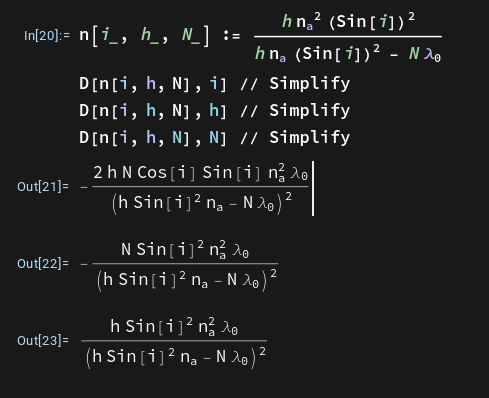

In [10]:
def denom(i, h, N):
    return h * nar**2 * np.sin(i)**2 - N*lamb0

def Dnv_i(i, h, N):
    return (-h * N* np.sin(2*i) * nar**2 * lamb0) / (denom(i,h,N)**2)

def Dnv_h(i,h,N):
    return (-N * np.sin(i)**2 * nar**2 * lamb0) / (denom(i,h,N)**2)

def Dnv_N(i,h,N):
    return (h * np.sin(i)**2 * nar**2 * lamb0) / (denom(i,h,N)**2)

#yikes, espero que tenhas paciência para confirmar se isto está bem

Para cada ensaio a incerteza será dada pela fórmula usual

In [26]:
u_h = 0.5e-3
u_i = 0.1 * np.pi/180 #menor divisão da escala
u_N = 1 #opa margem de erro 1, a contagem era lixada

u_nv_list = np.sqrt(
    (Dnv_i(i, h, Ng)*u_i)**2 + 
    (Dnv_h(i, h, Ng)*u_h)**2 +
    (Dnv_N(i, h, Ng)*u_N)**2
)

mean_u_nv = np.mean(u_nv_list) #media das incertezas
#queremos a incerteza da média:
u_nv_mean = 1/len(u_nv_list)*np.sqrt(np.sum(u_nv_list**2)) * 3 #com cobertura 3 ig
u_nv_mean

np.float64(0.15279934731282468)

### Dados dos padrões de difração (medidos com régua):
Por ordem de registo neste notebook: 
    
    - 0.02 mm
    - 0.04 mm
    - 0.08 mm 
    - Miguel
    - Faias
    - abertura circular d = 0.2mm

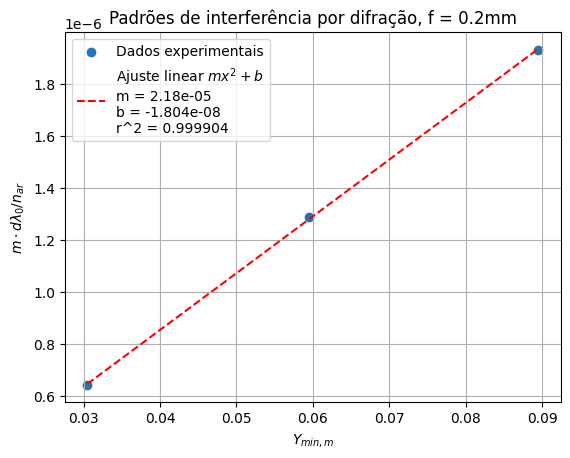

In [161]:
#fenda 0.02mm
f02 = np.array([6.1, 11.9, 17.9])*0.5*0.01
f02d = 1.00
m02 = np.array([1,2,3])*f02d*lamb0/n_ar
paramsf02, mcf02 = curve_fit(linearf, f02, m02)
r2f02 = r2(m02, linearf(f02, paramsf02[0], paramsf02[1]))

plt.scatter(f02, m02, label = "Dados experimentais")
plt.plot(f02, linearf(f02, paramsf02[0], paramsf02[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsf02[0]:.4}\nb = {paramsf02[1]:.4} \nr^2 = {r2f02:.6}')
plt.title("Padrões de interferência por difração, f = 0.2mm")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min,m}$")
plt.grid()
plt.legend()
plt.show()

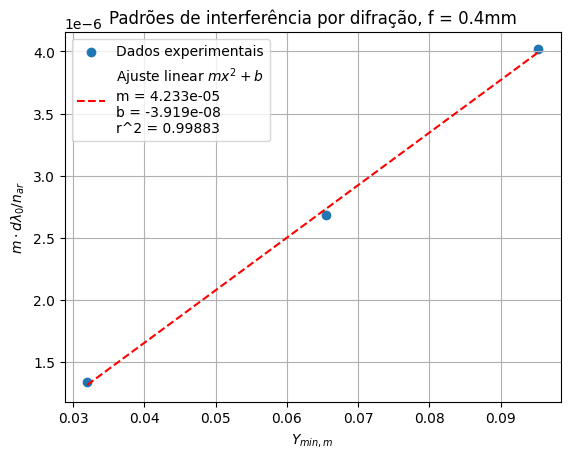

In [138]:
#fenda 0.04mm
f04 = np.array([6.4, 13.1, 19.05])*0.5*0.01
f04d = 2.084
m04 = np.array([1,2,3])*f04d*lamb0/n_ar
paramsf04, mcf04 = curve_fit(linearf, f04, m04)
r2f04 = r2(m04, linearf(f04, paramsf04[0], paramsf04[1]))

plt.scatter(f04, m04, label = "Dados experimentais")
plt.plot(f04, linearf(f04, paramsf04[0], paramsf04[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsf04[0]:.4}\nb = {paramsf04[1]:.4} \nr^2 = {r2f04:.6}')
plt.title("Padrões de interferência por difração, f = 0.4mm")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min,m}$")
plt.grid()
plt.legend()
plt.show()

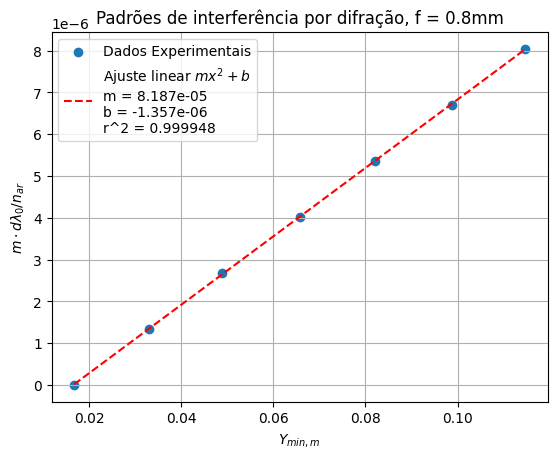

In [140]:
#fenda 0.08mm
f08 = np.array([3.35, 6.6, 9.77, 13.16, 16.4, 19.75, 22.93])*0.5*0.01
f08d = 2.084
m08 = np.array([i for i in range(len(f08))])*f08d*lamb0/n_ar
paramsf08, mcf08 = curve_fit(linearf, f08, m08)
r2f08 = r2(m08, linearf(f08, paramsf08[0], paramsf08[1]))

plt.scatter(f08, m08, label = "Dados Experimentais")
plt.plot(f08, linearf(f08, paramsf08[0], paramsf08[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsf08[0]:.4}\nb = {paramsf08[1]:.4} \nr^2 = {r2f08:.6}')
plt.title("Padrões de interferência por difração, f = 0.8mm")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min,m}$")
plt.grid()
plt.legend()
plt.show()

In [65]:
print(paramsf02[0], mcf02[0,0]**(1/2))
print(paramsf04[0], mcf04[0,0]**(1/2))
print(paramsf08[0], mcf08[0,0]**(1/2))
#nada mau

2.1797262111287344e-05 2.1329940384434504e-07
4.2327650441236675e-05 1.4488867046829543e-06
8.186557645114317e-05 2.648903092484843e-07


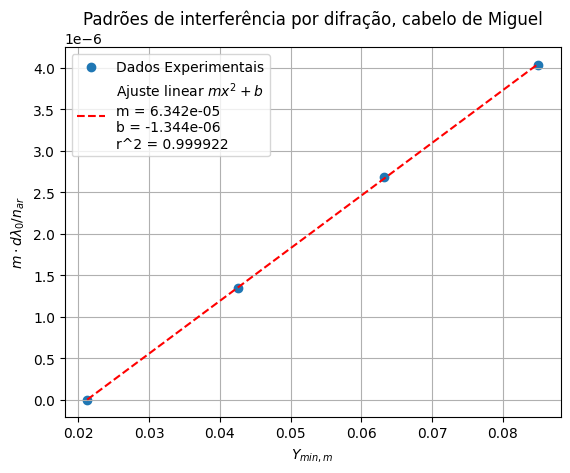

In [150]:
#Miguel
Miguel = np.array([4.25, 8.5, 12.65, 17])*0.5*0.01
Migueld = 2.091
mMiguel = np.array([i for i in range(len(Miguel))])*Migueld*lamb0/n_ar
paramsMiguel, mcMiguel = curve_fit(linearf, Miguel, mMiguel)
r2Miguel = r2(mMiguel, linearf(Miguel, paramsMiguel[0], paramsMiguel[1]))

plt.scatter(Miguel, mMiguel, label = "Dados Experimentais")
plt.plot(Miguel, linearf(Miguel, paramsMiguel[0], paramsMiguel[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsMiguel[0]:.4}\nb = {paramsMiguel[1]:.4} \nr^2 = {r2Miguel:.6}')
plt.title("Padrões de interferência por difração, cabelo de Miguel")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min,m}$")
plt.grid()
plt.legend()
plt.show()


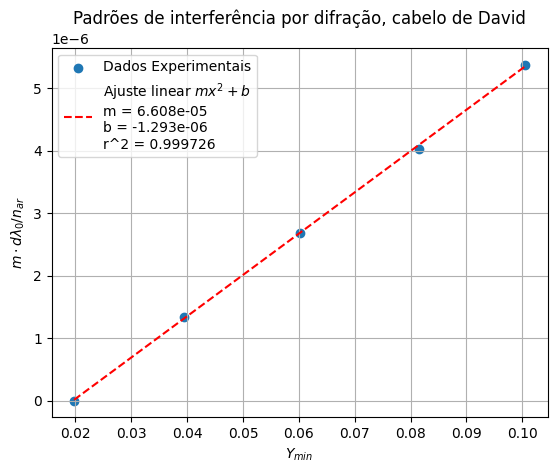

In [157]:
#Faias
Faias = np.array([3.95, 7.9, 12.03, 16.29, 20.1])*0.5*0.01
Faiasd = 2.091
mFaias = np.array([i for i in range(len(Faias))])*Faiasd*lamb0/n_ar
paramsFaias, mcFaias = curve_fit(linearf, Faias, mFaias)
r2Faias = r2(mFaias, linearf(Faias, paramsFaias[0], paramsFaias[1]))

plt.scatter(Faias, mFaias, label = "Dados Experimentais")
plt.plot(Faias, linearf(Faias, paramsFaias[0], paramsFaias[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsFaias[0]:.4}\nb = {paramsFaias[1]:.4} \nr^2 = {r2Faias:.6}')
plt.title("Padrões de interferência por difração, cabelo de David")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min}$")
plt.grid()
plt.legend()
plt.show()


In [77]:
print(paramsMiguel[0], mcMiguel[0,0]**(1/2))
print(paramsFaias[0], mcFaias[0,0]**(1/2))

6.342345556874749e-05 3.9576106012612916e-07
6.607589457889063e-05 6.310906692424195e-07


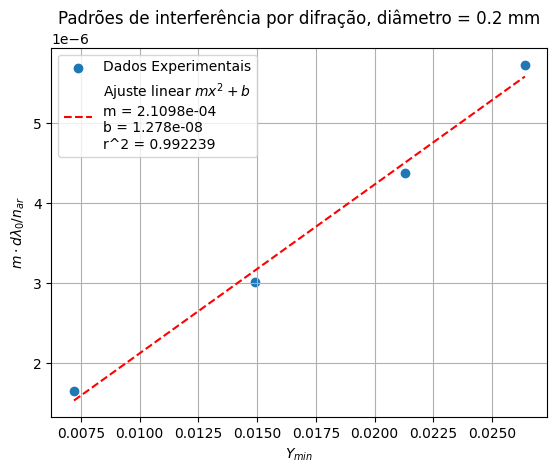

In [156]:
#circular aperture d = 0.2 mm
ca2 = np.array([0.72, 1.49, 2.13, 2.64])*0.01
ca2d = 2.102
mca2= np.array([3.83171, 7.01559, 10.1735, 13.3237])*ca2d*lamb0/n_ar/np.pi
paramsca2, mcca2 = curve_fit(linearf, ca2, mca2)
r2ca2 = r2(mca2, linearf(ca2, paramsca2[0], paramsca2[1]))

plt.scatter(ca2, mca2, label = "Dados Experimentais")
plt.plot(ca2, linearf(ca2, paramsca2[0], paramsca2[1]), color = "r", ls = "--", 
         label =  f'Ajuste linear $m x^2 + b$ \nm = {paramsca2[0]:.4e}\nb = {paramsca2[1]:.4} \nr^2 = {r2ca2:.6}')
plt.title("Padrões de interferência por difração, diâmetro = 0.2 mm")
plt.ylabel(r"$ m \cdot d \lambda_0 / n_{ar}$")
plt.xlabel(r"$Y_{min}$")
plt.grid()
plt.legend()
plt.show()

## Condensei aqui os resultados imporantes:
(Para as regressões, acho que os labels dos gráficos explicam oq fiz às variáveis)

(tive de ir à net buscar o quarto zero da função de bessel n=1, que já agora era 13,324, se por acaso estavas curioso ☝️🤓)

In [162]:
print(f"Fenda 0.02mm: {paramsf02[0]:.3e} {mcf02[0,0]**(1/2):.1e}")
print(f"Fenda 0.04mm: {paramsf04[0]:.3e} {mcf04[0,0]**(1/2):.1e}")
print(f"Fenda 0.08mm: {paramsf08[0]:.3e} {mcf08[0,0]**(1/2):.1e}")
print(f"Miguel com cabelo minúsculo: {paramsMiguel[0]:.3e} {mcMiguel[0,0]**(1/2):.1e}")
print(f"Faias com cabelo másculo, robusto e viril: {paramsFaias[0]:.1e}, {mcFaias[0,0]**(1/2):.1e}")
print(f"Abertura circular, diametro = 0.2mm: {paramsca2[0]:.3e} {mcca2[0,0]**(1/2):.1e}")

Fenda 0.02mm: 2.180e-05 2.1e-07
Fenda 0.04mm: 4.233e-05 1.4e-06
Fenda 0.08mm: 8.187e-05 2.6e-07
Miguel com cabelo minúsculo: 6.342e-05 4.0e-07
Faias com cabelo másculo, robusto e viril: 6.6e-05, 6.3e-07
Abertura circular, diametro = 0.2mm: 2.110e-04 1.3e-05
